# Data Generation - Variational Auto Encoder (VAE)

In [1]:
import os
import math
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from vr_recognition.data import Data
from vr_recognition.hardware import Hardware
from vr_recognition.model_utils import ModelUtils
from vr_recognition.nets.vr_gesture_recognizer import VRGestureRecognizer
from vr_recognition.hardware import Hardware
from vr_recognition.nets.ccvae.net import CCVAE

In [3]:
base_dir: str = os.path.join(os.getcwd(), 'simulated_data_v2')

tuple_data: tuple[list[pd.DataFrame], np.ndarray, np.ndarray] = Data.load_data(base_dir)

# Unpack data
pd_data: list[pd.DataFrame] = tuple_data[0]
labels: np.ndarray = tuple_data[1]
classes: np.ndarray = tuple_data[2]

0 VRAI HORIZONTAL
1 FAUX HORIZONTAL
2 FAUX VERTICAL
3 VRAI VERTICAL
4 NON VERTICAL
5 NON HORIZONTAL
6 OUI VERTICAL
7 OUI HORIZONTAL


In [4]:
data: np.ndarray = Data.convert_to_numpy(pd_data)

## Data Generation

### Class Conditional Variational Autoencoder (CCVAE)

<u>**Log-variance:**</u><br><br>
Instead of learning the variance $\sigma^2$, we here learn the log-variance $\log(\sigma^2)$ because it can take any real number, while the variance can only take positive values. We can then exponentiate the log-variance to get the variance. Here is how we can do this:<br>

$$\log(\sigma^2) = 2 * \log(\sigma)$$
$$\log(\sigma^2) / 2 = \log(\sigma)$$
$$e^{\log(\sigma^2) / 2} = \sigma$$

### Training

In [5]:
seed: int = 42
torch.manual_seed(seed)
torch.mps.manual_seed(seed)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=seed)

ccvae = CCVAE(hidden_dim=32, latent_dim=32, input_shape=data.shape[1:]).to_device()
ccvae.fit(X_train, X_val, y_train, y_val, epochs=50, learning_rate=1e-3, batch_size=4)

Training on 27 batches, validating on 5 batches


  0%|          | 0/50 [00:00<?, ?it/s]

#### History - Training & Validation Loss

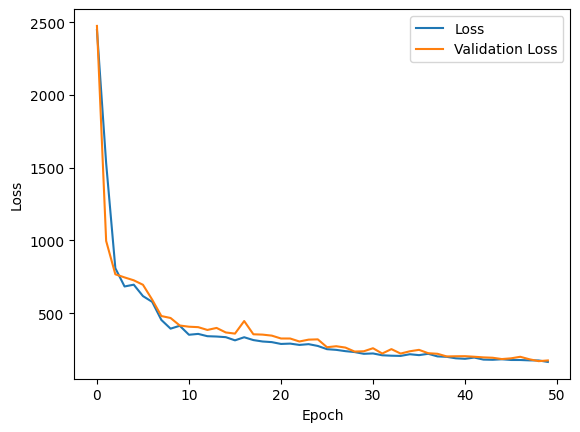

In [6]:
ccvae.plot_history()

### Evaluation - CCVAE

In [7]:
ccvae.evaluate(X_test, y_test, batch_size=4)

Test loss: 18.9204


### Generation of new samples

In [8]:
n_samples = 5000
generation_seed = 90

torch.manual_seed(generation_seed)
X_gen, y_gen = ccvae.sample(n=n_samples)

In [9]:
# Run inference on previously trained classification model
# classified_output = ModelUtils.run_pytorch_inference(path="models/random_forest.onnx", input=X_gen)

from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=45)

rf_classifier = RandomForestClassifier(
    n_estimators=1000,
    max_depth=512,
    class_weight='balanced',
    random_state=42
)

rf_classifier.fit(X_train.reshape(X_train.shape[0], -1), y_train)
print("Test accuracy: {:.2f}%".format(rf_classifier.score(X_test.reshape(X_test.shape[0], -1), y_test) * 100))

classified_output = rf_classifier.predict(X_gen.reshape(X_gen.shape[0], -1))

accuracy = accuracy_score(y_gen, classified_output)
print(f"Generation accuracy: {accuracy * 100:.2f}%")

# Keep only the correctly classified samples
X_gen_c = X_gen[classified_output == y_gen]
y_gen_c = y_gen[classified_output == y_gen]

Test accuracy: 100.00%
Generation accuracy: 27.90%


### Saving newly generated samples

In [10]:
np.save(os.path.join("fake_data", "X_gen.npy"), X_gen_c)
np.save(os.path.join("fake_data", "y_gen.npy"), y_gen_c)

## Classification

### Model

  0%|          | 0/20 [00:00<?, ?it/s]

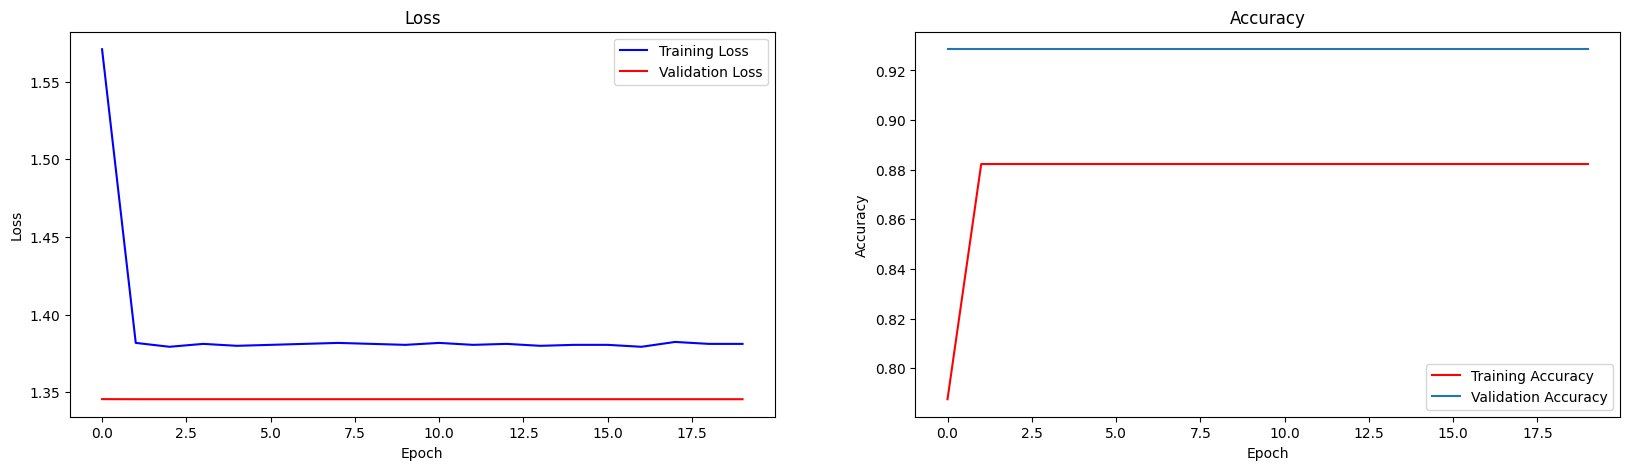

In [11]:
DEVICE = Hardware.device()
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4
HIDDEN_SIZE = 128
NUM_LABELS = classes.shape[0]

# Loss function
loss_fn = nn.CrossEntropyLoss()

gesture_recognizer = VRGestureRecognizer(hidden_size=HIDDEN_SIZE, num_classes=NUM_LABELS).to(DEVICE)

X_train, X_test, y_train, y_test = train_test_split(X_gen_c.squeeze(1), y_gen_c, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

gesture_recognizer.compile(loss_fn=loss_fn)
training_history = gesture_recognizer.fit(X_train, y_train, X_val, y_val, epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE)

gesture_recognizer.plot_history()

### Evaluation on real data

In [12]:
# Test on real data
test_loss, test_accuracy = gesture_recognizer.to(Hardware.device()).evaluate(data, labels)
print(f"Loss: {test_loss.item():.2f} | Accuracy: {test_accuracy * 100:.2f}%")

Loss: 2.15 | Accuracy: 12.50%


### Exporting the model

In [13]:
if not os.path.exists('models'):
    os.mkdir('models')

In [14]:
gesture_recognizer.export_to_onnx(path='models/vr_artifical_gesture_recognizer.onnx', data_shape=data.shape[1:])

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

